# **Fine-tuning Wav2Vec2 for English ASR with 🤗 Transformers**

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')


[source](https://colab.research.google.com/github/patrickvonplaten/notebooks/blob/master/Fine_tuning_Wav2Vec2_for_English_ASR.ipynb#scrollTo=WPq-vSxfT4w8)

Wav2Vec2 is a pretrained model for Automatic Speech Recognition (ASR) and was released in [September 2020](https://ai.facebook.com/blog/wav2vec-20-learning-the-structure-of-speech-from-raw-audio/) by Alexei Baevski, Michael Auli, and Alex Conneau.

Using a novel contrastive pretraining objective, Wav2Vec2 learns powerful speech representations from more than 50.000 hours of unlabeled speech. Similar, to [BERT's masked language modeling](http://jalammar.github.io/illustrated-bert/), the model learns contextualized speech representations by randomly masking feature vectors before passing them to a transformer network.

![wav2vec2_structure](https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/wav2vec2.png)

For the first time, it has been shown that pretraining, followed by fine-tuning on very little labeled speech data achieves competitive results to state-of-the-art ASR systems. Using as little as 10 minutes of labeled data, Wav2Vec2 yields a word error rate (WER) of less than 5% on the clean test set of [LibriSpeech](https://huggingface.co/datasets/librispeech_asr) - *cf.* with Table 9 of the [paper](https://arxiv.org/pdf/2006.11477.pdf).

In this notebook, we will give an in-detail explanation of how Wav2Vec2's pretrained checkpoints can be fine-tuned on any English ASR dataset. Note that in this notebook, we will fine-tune Wav2Vec2 without making use of a language model. It is much simpler to use Wav2Vec2 without a language model as an end-to-end ASR system and it has been shown that a standalone Wav2Vec2 acoustic model achieves impressive results. For demonstration purposes, we fine-tune the "base"-sized [pretrained checkpoint](https://huggingface.co/facebook/wav2vec2-base) on the rather small [Timit](https://huggingface.co/datasets/timit_asr) dataset that contains just 5h of training data.

Wav2Vec2 is fine-tuned using Connectionist Temporal Classification (CTC), which is an algorithm that is used to train neural networks for sequence-to-sequence problems and mainly in Automatic Speech Recognition and handwriting recognition. 

I highly recommend reading the blog post [Sequence Modeling with CTC (2017)](https://distill.pub/2017/ctc/) very well-written blog post by Awni Hannun.

First, let's try to get a good GPU in our colab! With Google Colab's free version it's sadly becoming much harder to get access to a good GPU. With Google Colab Pro, one has a much easier time getting access to a V100 or P100 GPU however.

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue May  3 12:20:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000001:00:00.0 Off |                    0 |
| N/A   35C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           On   | 00000002:00:00.0 Off |                    0 |
| N/A   

Before we start, let's install both `datasets` and `transformers` from master. Also, we need the `librosa` package to load audio files and the `jiwer` to evaluate our fine-tuned model using the [word error rate (WER)](https://huggingface.co/metrics/wer) metric ${}^1$.

In [3]:
%%capture
!pip install datasets==1.18.3
!pip install transformers==4.11.3
!pip install librosa
!pip install jiwer

Next we strongly suggest to upload your training checkpoints directly to the [🤗 Hub](https://huggingface.co/) while training. The [🤗 Hub](https://huggingface.co/) has integrated version control so you can be sure that no model checkpoint is getting lost during training. 

To do so you have to store your authentication token from the Hugging Face website (sign up [here](https://huggingface.co/join) if you haven't already!)

In [3]:
#from huggingface_hub import notebook_login
#notebook_login()
!huggingface-cli login


        _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
        _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
        _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
        _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
        _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

        To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/tokens.
        (Deprecated, will be removed in v0.3.0) To login with username and password instead, interrupt with Ctrl+C.
        
Username: 


Then you need to install Git-LFS to upload your model checkpoints:

In [3]:
%%capture
!apt install git-lfs




---

${}^1$ Timit is usually evaluated using the phoneme error rate (PER), but by far the most common metric in ASR is the word error rate (WER). To keep this notebook as general as possible we decided to evaluate the model using WER.

## Prepare Data, Tokenizer, Feature Extractor

ASR models transcribe speech to text, which means that we both need a feature extractor that processes the speech signal to the model's input format, *e.g.* a feature vector, and a tokenizer that processes the model's output format to text. 

In 🤗 Transformers, the Wav2Vec2 model is thus accompanied by both a tokenizer, called [Wav2Vec2CTCTokenizer](https://huggingface.co/transformers/master/model_doc/wav2vec2.html#wav2vec2ctctokenizer), and a feature extractor, called [Wav2Vec2FeatureExtractor](https://huggingface.co/transformers/master/model_doc/wav2vec2.html#wav2vec2featureextractor).

Let's start by creating the tokenizer responsible for decoding the model's predictions.

### Create Wav2Vec2CTCTokenizer

The [pretrained Wav2Vec2 checkpoint]( ) maps the speech signal to a sequence of context representations as illustrated in the figure above. A fine-tuned Wav2Vec2 checkpoint needs to map this sequence of context representations to its corresponding transcription so that a linear layer has to be added on top of the transformer block (shown in yellow). This linear layer is used to classifies each context representation to a token class analogous how, *e.g.*, after pretraining a linear layer is added on top of BERT's embeddings for further classification - *cf.* with *"BERT"* section of this [blog post](https://huggingface.co/blog/warm-starting-encoder-decoder).

The output size of this layer corresponds to the number of tokens in the vocabulary, which does **not** depend on Wav2Vec2's pretraining task, but only on the labeled dataset used for fine-tuning. So in the first step, we will take a look at Timit and define a vocabulary based on the dataset's transcriptions.

Let's start by loading the dataset and taking a look at its structure.

https://huggingface.co/docs/datasets/audio_process



https://discuss.huggingface.co/t/json-dump-format-for-load-dataset/9974

In [4]:
%%capture
%pip install datasets[audio]

Many ASR datasets only provide the target text, `'text'` for each audio `'audio'` and file `'file'`. Timit actually provides much more information about each audio file, such as the `'phonetic_detail'`, etc., which is why many researchers choose to evaluate their models on phoneme classification instead of speech recognition when working with Timit. However, we want to keep the notebook as general as possible, so that we will only consider the transcribed text for fine-tuning.



In [50]:
from datasets import load_dataset, load_metric, Audio, ReadInstruction

ri = {'train': ReadInstruction('train'), 'test': ReadInstruction('test')}
tcrs = load_dataset('json', data_files='tcrs_1.json')
dataset = tcrs['train'].cast_column("audio", Audio(sampling_rate=16000))
dataset[-1]['audio']

Using custom data configuration default-cfdfce205b4ea499
Reusing dataset json (/home/azureuser/.cache/huggingface/datasets/json/default-cfdfce205b4ea499/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b)


  0%|          | 0/1 [00:00<?, ?it/s]

{'path': '/home/azureuser/cloudfiles/code/Users/neelan/asr/pipeline/data/10100349937363#760#NATRISHAM#TCRDBN1-A01#20220215072428404.wav',
 'array': array([ 0.        ,  0.        ,  0.        , ..., -0.00109863,
        -0.00115967, -0.00115967], dtype=float32),
 'sampling_rate': 16000}

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe9e03c7ac0>]],
      dtype=object)

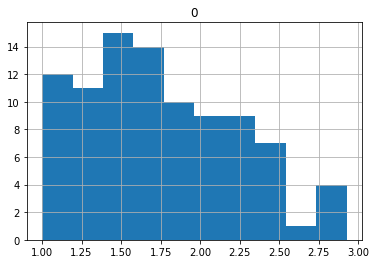

In [56]:
import pandas as pd
pd.DataFrame(dataset['words_per_second']).hist()


In [117]:
# setting max for duration_seconds to fit on a single K80 GPU
dataset = dataset.filter(lambda example: example['duration_seconds'] <= 300.0)

# best supervision for training
train = dataset.filter(lambda example: example['words_per_second'] > 1.5)
train = train.sort('words_per_second',True)

valid = dataset.filter(lambda example: example['words_per_second'] <= 1.5)


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe983246e20>]],
      dtype=object)

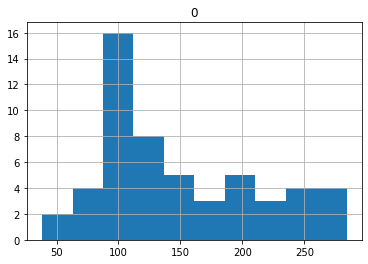

In [118]:
pd.DataFrame(train["duration_seconds"]).hist()

Let's write a short function to display some random samples of the dataset and run it a couple of times to get a feeling for the transcriptions.

In [119]:
from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    display(HTML(df.to_html()))

In [ ]:
show_random_elements(dataset, num_examples=3)

Alright! The transcriptions look very clean and the language seems to correspond more to written text than dialogue. This makes sense taking into account that [Timit](https://huggingface.co/datasets/timit_asr) is a read speech corpus.

We can see that the transcriptions contain some special characters, such as `,.?!;:`. Without a language model, it is much harder to classify speech chunks to such special characters because they don't really correspond to a characteristic sound unit. *E.g.*, the letter `"s"` has a more or less clear sound, whereas the special character `"."` does not.
Also in order to understand the meaning of a speech signal, it is usually not necessary to include special characters in the transcription.

In addition, we normalize the text to only have lower case letters and append a word separator token at the end.

In [120]:
import re
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"]'

def remove_special_characters(batch):
    batch["text"] = re.sub(chars_to_ignore_regex, '', batch["text"]).lower() + " "
    return batch

In [121]:
dataset = dataset.map(remove_special_characters)
train = train.map(remove_special_characters)
valid = valid.map(remove_special_characters)

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

Good! This looks better. We have removed most special characters from transcriptions and normalized them to lower-case only.

In CTC, it is common to classify speech chunks into letters, so we will do the same here. 
Let's extract all distinct letters of the training and test data and build our vocabulary from this set of letters.

We write a mapping function that concatenates all transcriptions into one long transcription and then transforms the string into a set of chars. 
It is important to pass the argument `batched=True` to the `map(...)` function so that the mapping function has access to all transcriptions at once.

In [122]:
def extract_all_chars(batch):
  all_text = " ".join(batch["text"])
  vocab = list(set(all_text))
  return {"vocab": [vocab], "all_text": [all_text]}


In [123]:
vocabs =dataset.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=dataset.column_names) 
vocabs_train = train.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=train.column_names)
vocabs_valid = valid.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=valid.column_names)  

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [124]:
#vocab_list = list(set(vocabs["train"]["vocab"][0]) | set(vocabs["test"]["vocab"][0]))
vocab_list = list(set(vocabs_train["vocab"][0]) | set(vocabs_valid["vocab"][0]))
len(vocab_list)

37

In [125]:
#vocab_dict = {v: k for k, v in enumerate(vocab_list)}

### our vocab dict has numbers & currency --> probably need to find and replace numbers to words
vocab_dict = {v: k for k, v in enumerate(vocab_list)}

Cool, we see that all letters of the alphabet occur in the dataset (which is not really surprising) and we also extracted the special characters `" "` and `'`. Note that we did not exclude those special characters because: 

- The model has to learn to predict when a word finished or else the model prediction would always be a sequence of chars which would make it impossible to separate words from each other.
- In English, we need to keep the `'` character to differentiate between words, *e.g.*, `"it's"` and `"its"` which have very different meanings.

To make it clearer that `" "` has its own token class, we give it a more visible character `|`. In addition, we also add an "unknown" token so that the model can later deal with characters not encountered in Timit's training set. 

Finally, we also add a padding token that corresponds to CTC's "*blank token*". The "blank token" is a core component of the CTC algorithm. For more information, please take a look at the "Alignment" section [here](https://distill.pub/2017/ctc/).

In [126]:
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

In [127]:
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
print(len(vocab_dict))

39


Cool, now our vocabulary is complete and consists of 30 tokens, which means that the linear layer that we will add on top of the pretrained Wav2Vec2 checkpoint will have an output dimension of 30.

Let's now save the vocabulary as a json file.

In [128]:
import json
    
with open('vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

In a final step, we use the json file to instantiate an object of the `Wav2Vec2CTCTokenizer` class.

In [129]:
from transformers import Wav2Vec2CTCTokenizer

tokenizer = Wav2Vec2CTCTokenizer("./vocab.json", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")

If one wants to re-use the just created tokenizer with the fine-tuned model of this notebook, it is strongly advised to upload the `tokenizer` to the [🤗 Hub](https://huggingface.co/). Let's call the repo to which we will upload the files
`"wav2vec2-base-timit-demo-colab"`:

In [130]:
repo_name = "wav2vec2-tcrs"

and upload the tokenizer to the [🤗 Hub](https://huggingface.co/).

In [131]:
tokenizer.push_to_hub(repo_name)

tokenizer config file saved in wav2vec2-tcrs/tokenizer_config.json
Special tokens file saved in wav2vec2-tcrs/special_tokens_map.json


Great, you can see the just created repository under `https://huggingface.co/<your-username>/wav2vec2-base-timit-demo-colab`

### Create Wav2Vec2 Feature Extractor

Speech is a continuous signal and to be treated by computers, it first has to be discretized, which is usually called **sampling**. The sampling rate hereby plays an important role in that it defines how many data points of the speech signal are measured per second. Therefore, sampling with a higher sampling rate results in a better approximation of the *real* speech signal but also necessitates more values per second.

A pretrained checkpoint expects its input data to have been sampled more or less from the same distribution as the data it was trained on. The same speech signals sampled at two different rates have a very different distribution, *e.g.*, doubling the sampling rate results in data points being twice as long. Thus, 
before fine-tuning a pretrained checkpoint of an ASR model, it is crucial to verify that the sampling rate of the data that was used to pretrain the model matches the sampling rate of the dataset used to fine-tune the model.

Wav2Vec2 was pretrained on the audio data of [LibriSpeech](https://huggingface.co/datasets/librispeech_asr) and LibriVox which both were sampling with 16kHz. Our fine-tuning dataset, [Timit](hhtps://huggingface.co/datasets/timit_asr), was luckily also sampled with 16kHz. If the fine-tuning dataset would have been sampled with a rate lower or higher than 16kHz, we first would have had to up or downsample the speech signal to match the sampling rate of the data used for pretraining. 



A Wav2Vec2 feature extractor object requires the following parameters to be instantiated:

- `feature_size`: Speech models take a sequence of feature vectors as an input. While the length of this sequence obviously varies, the feature size should not. In the case of Wav2Vec2, the feature size is 1 because the model was trained on the raw speech signal ${}^2$.
- `sampling_rate`: The sampling rate at which the model is trained on.
- `padding_value`: For batched inference, shorter inputs need to be padded with a specific value
- `do_normalize`: Whether the input should be *zero-mean-unit-variance* normalized or not. Usually, speech models perform better when normalizing the input
- `return_attention_mask`: Whether the model should make use of an `attention_mask` for batched inference. In general, models should **always** make use of the `attention_mask` to mask padded tokens. However, due to a very specific design choice of `Wav2Vec2`'s "base" checkpoint, better results are achieved when using no `attention_mask`. This is **not** recommended for other speech models. For more information, one can take a look at [this](https://github.com/pytorch/fairseq/issues/3227) issue. **Important** If you want to use this notebook to fine-tune [large-lv60](https://huggingface.co/facebook/wav2vec2-large-lv60), this parameter should be set to `True`.

In [132]:
from transformers import Wav2Vec2FeatureExtractor

feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, ampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=False)

Great, Wav2Vec2's feature extraction pipeline is thereby fully defined!

To make the usage of Wav2Vec2 as user-friendly as possible, the feature extractor and tokenizer are *wrapped* into a single `Wav2Vec2Processor` class so that one only needs a `model` and `processor` object.

In [133]:
from transformers import Wav2Vec2Processor

processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

Next, we can prepare the dataset.

### Preprocess Data

So far, we have not looked at the actual values of the speech signal but just the transcription. In addition to `'text'`, our datasets include two more column names `'file'` and `'audio'`. `'file'` states the absolute path of the audio file. Let's take a look.

`Wav2Vec2` expects the input in the format of a 1-dimensional array of 16 kHz. This means that the audio file has to be loaded and resampled.

 Thankfully, `datasets` does this automatically when calling the column `audio`. Let try it out. 

We can see that the audio file has automatically been loaded. This is thanks to the new [`"Audio"` feature](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=audio#datasets.Audio) introduced in `datasets == 4.13.3`, which loads and resamples audio files on-the-fly upon calling.

The sampling rate is set to 16kHz which is what `Wav2Vec2` expects as an input.

Great, let's listen to a couple of audio files to better understand the dataset and verify that the audio was correctly loaded. 

**Note**: *You can click the following cell a couple of times to listen to different speech samples.*

In [ ]:
import IPython.display as ipd
import numpy as np
import random

rand_int = random.randint(0, len(timit["train"]))

print(timit["train"][rand_int]["text"])
ipd.Audio(data=np.asarray(timit["train"][rand_int]["audio"]["array"]), autoplay=True, rate=16000)

No more startling contrast to a system of sullen satellites could be imagined.


It can be heard, that the speakers change along with their speaking rate, accent, etc. Overall, the recordings sound relatively clear though, which is to be expected from a read speech corpus.

Let's do a final check that the data is correctly prepared, by printing the shape of the speech input, its transcription, and the corresponding sampling rate.

**Note**: *You can click the following cell a couple of times to verify multiple samples.*

In [ ]:
rand_int = random.randint(0, len(timit["train"]))

print("Target text:", timit["train"][rand_int]["text"])
print("Input array shape:", np.asarray(timit["train"][rand_int]["audio"]["array"]).shape)
print("Sampling rate:", timit["train"][rand_int]["audio"]["sampling_rate"])

Target text: she had your dark suit in greasy wash water all year 
Input array shape: (57242,)
Sampling rate: 16000


Good! Everything looks fine - the data is a 1-dimensional array, the sampling rate always corresponds to 16kHz, and the target text is normalized.

Finally, we can process the dataset to the format expected by the model for training. We will make use of the `map(...)` function.

First, we load and resample the audio data, simply by calling `batch["audio"]`.
Second, we extract the `input_values` from the loaded audio file. In our case, the `Wav2Vec2Processor` only normalizes the data. For other speech models, however, this step can include more complex feature extraction, such as [Log-Mel feature extraction](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum).
Third, we encode the transcriptions to label ids.

**Note**: This mapping function is a good example of how the `Wav2Vec2Processor` class should be used. In "normal" context, calling `processor(...)` is redirected to `Wav2Vec2FeatureExtractor`'s call method. When wrapping the processor into the `as_target_processor` context, however, the same method is redirected to `Wav2Vec2CTCTokenizer`'s call method.
For more information please check the [docs](https://huggingface.co/transformers/master/model_doc/wav2vec2.html#transformers.Wav2Vec2Processor.__call__).

In [69]:
dataset[0]['text']

'hello hi can i speak to lenny youre speaking to carabo from mpd legal can you kindly confirm date of birth for security check okay thank you i was calling in connection with your mr praise account which is an outstanding balance of 710 '

https://huggingface.co/docs/datasets/audio_process

In [ ]:
#%pip install datasets[audio]
#!sudo apt-get install libsndfile1

In [134]:
import torchaudio
import numpy as np

def prepare_dataset(batch):
    audio = batch["audio"]

    # batched output is "un-batched" to ensure mapping is correct
 
    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    batch["input_length"] = len(batch["input_values"])
    
    with processor.as_target_processor():
        batch["labels"] = processor(batch["text"]).input_ids
    return batch

Let's apply the data preparation function to all examples.

# reinstantiate data
#timit = load_dataset("timit_asr")
#timit = timit.remove_columns(["phonetic_detail", "word_detail", "dialect_region", "id", "sentence_type", "speaker_id"])
train = load_dataset('json', data_files='train_hf.json',field='data')
valid = load_dataset('json', data_files='valid_hf.json',field='data')
test = load_dataset('json', data_files='test_hf.json',field='data')

#timit = timit.map(remove_special_characters)
train = train.map(remove_special_characters_)
valid = valid.map(remove_special_characters_)
test = test.map(remove_special_characters_)


In [135]:
dataset = dataset.map(prepare_dataset,num_proc=4)
train = train.map(prepare_dataset, num_proc=4)
valid = valid.map(prepare_dataset, num_proc=4)

**Note**: Currently `datasets` make use of [`torchaudio`](https://pytorch.org/audio/stable/index.html) and [`librosa`](https://librosa.org/doc/latest/index.html) for audio loading and resampling. If you wish to implement your own costumized data loading/sampling, feel free to just make use of the `"path"` column instead and disregard the `"audio"` column.

Long input sequences require a lot of memory. Since `Wav2Vec2` is based on `self-attention` the memory requirement scales quadratically with the input length for long input sequences (*cf.* with [this](https://www.reddit.com/r/MachineLearning/comments/genjvb/d_why_is_the_maximum_input_sequence_length_of/) reddit post). For this demo, let's filter all sequences that are longer than 4 seconds out of the training dataset.

Awesome, now we are ready to start training!

## Training & Evaluation

The data is processed so that we are ready to start setting up the training pipeline. We will make use of 🤗's [Trainer](https://huggingface.co/transformers/master/main_classes/trainer.html?highlight=trainer) for which we essentially need to do the following:

- Define a data collator. In contrast to most NLP models, Wav2Vec2 has a much larger input length than output length. *E.g.*, a sample of input length 50000 has an output length of no more than 100. Given the large input sizes, it is much more efficient to pad the training batches dynamically meaning that all training samples should only be padded to the longest sample in their batch and not the overall longest sample. Therefore, fine-tuning Wav2Vec2 requires a special padding data collator, which we will define below

- Evaluation metric. During training, the model should be evaluated on the word error rate. We should define a `compute_metrics` function accordingly

- Load a pretrained checkpoint. We need to load a pretrained checkpoint and configure it correctly for training.

- Define the training configuration.

After having fine-tuned the model, we will correctly evaluate it on the test data and verify that it has indeed learned to correctly transcribe speech.

### Set-up Trainer

Let's start by defining the data collator. The code for the data collator was copied from [this example](https://github.com/huggingface/transformers/blob/9a06b6b11bdfc42eea08fa91d0c737d1863c99e3/examples/research_projects/wav2vec2/run_asr.py#L81).

Without going into too many details, in contrast to the common data collators, this data collator treats the `input_values` and `labels` differently and thus applies to separate padding functions on them (again making use of Wav2Vec2's context manager). This is necessary because in speech input and output are of different modalities meaning that they should not be treated by the same padding function.
Analogous to the common data collators, the padding tokens in the labels with `-100` so that those tokens are **not** taken into account when computing the loss.

In [136]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [137]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

Next, the evaluation metric is defined. As mentioned earlier, the 
predominant metric in ASR is the word error rate (WER), hence we will use it in this notebook as well.

In [138]:
wer_metric = load_metric("wer")

The model will return a sequence of logit vectors:
$\mathbf{y}_1, \ldots, \mathbf{y}_m$ with $\mathbf{y}_1 = f_{\theta}(x_1, \ldots, x_n)[0]$ and $n >> m$.

A logit vector $\mathbf{y}_1$ contains the log-odds for each word in the vocabulary we defined earlier, thus $\text{len}(\mathbf{y}_i) =$ `config.vocab_size`. We are interested in the most likely prediction of the model and thus take the `argmax(...)` of the logits. Also, we transform the encoded labels back to the original string by replacing `-100` with the `pad_token_id` and decoding the ids while making sure that consecutive tokens are **not** grouped to the same token in CTC style ${}^1$.

In [139]:
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

Now, we can load the pretrained `Wav2Vec2` checkpoint. The tokenizer's `pad_token_id` must be to define the model's `pad_token_id` or in the case of `Wav2Vec2ForCTC` also CTC's *blank token* ${}^2$. To save GPU memory, we enable PyTorch's [gradient checkpointing](https://pytorch.org/docs/stable/checkpoint.html) and also set the loss reduction to "*mean*".

In [140]:
from transformers import Wav2Vec2ForCTC

model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-base", 
    ctc_loss_reduction="mean", 
    pad_token_id=processor.tokenizer.pad_token_id,
)

loading configuration file https://huggingface.co/facebook/wav2vec2-base/resolve/main/config.json from cache at /home/azureuser/.cache/huggingface/transformers/c7746642f045322fd01afa31271dd490e677ea11999e68660a92619ec7c892b4.ce1f96bfaf3d7475cb8187b9668c7f19437ade45fb9ceb78d2b06a2cec198015
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/transformers/configuration_utils.py:336: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Model config Wav2Vec2Config {
  "activation_dropout": 0.0,
  "apply_spec_augment": true,
  "architectures": [
    "Wav2Vec2ForPreTraining"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 1,
  "classifier_proj_size": 256,
  "codevector_dim": 256,
  "contrastive_logits_temperature": 0.1,
  "conv_bias": false,

The first component of Wav2Vec2 consists of a stack of CNN layers that are used to extract acoustically meaningful - but contextually independent - features from the raw speech signal. This part of the model has already been sufficiently trained during pretrainind and as stated in the [paper](https://arxiv.org/abs/2006.11477) does not need to be fine-tuned anymore. 
Thus, we can set the `requires_grad` to `False` for all parameters of the *feature extraction* part.

In a final step, we define all parameters related to training. 
To give more explanation on some of the parameters:
- `group_by_length` makes training more efficient by grouping training samples of similar input length into one batch. This can significantly speed up training time by heavily reducing the overall number of useless padding tokens that are passed through the model
- `learning_rate` and `weight_decay` were heuristically tuned until fine-tuning has become stable. Note that those parameters strongly depend on the Timit dataset and might be suboptimal for other speech datasets.

For more explanations on other parameters, one can take a look at the [docs](https://huggingface.co/transformers/master/main_classes/trainer.html?highlight=trainer#trainingarguments).

During training, a checkpoint will be uploaded asynchronously to the hub every 400 training steps. It allows you to also play around with the demo widget even while your model is still training.

**Note**: If one does not want to upload the model checkpoints to the hub, simply set `push_to_hub=False`.

In [141]:
model.config.vocab_size = len(vocabs['vocab'][0])
print(model.config.vocab_size)

37


In [142]:
from transformers import TrainingArguments


training_args = TrainingArguments(
  output_dir=repo_name,
  group_by_length=True,
  per_device_train_batch_size=1,
  evaluation_strategy="steps",
  num_train_epochs=30,
  fp16=True,
  gradient_checkpointing=True,
  save_steps=10,
  eval_steps=10,
  logging_steps=10,
  learning_rate=1e-4,
  weight_decay=0.005,
  warmup_steps=10,
  save_total_limit=2,
  push_to_hub=True,
  report_to="wandb",  # enable logging to W&B
  run_name="wav2vec2_hf_test"  # name of the W&B run (optional)
)

PyTorch: setting up devices


Now, all instances can be passed to Trainer and we are ready to start training!

In [143]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train,
    eval_dataset=valid,
    tokenizer=processor.feature_extractor,


)

/mnt/batch/tasks/shared/LS_root/mounts/clusters/asr-westeu-2gpu/code/Users/neelan/asr/pipeline/wav2vec2-tcrs is already a clone of https://huggingface.co/neonkitchen/wav2vec2-tcrs. Make sure you pull the latest changes with `repo.git_pull()`.
Using amp fp16 backend




---

${}^1$ To allow models to become independent of the speaker rate, in CTC, consecutive tokens that are identical are simply grouped as a single token. However, the encoded labels should not be grouped when decoding since they don't correspond to the predicted tokens of the model, which is why the `group_tokens=False` parameter has to be passed. If we wouldn't pass this parameter a word like `"hello"` would incorrectly be encoded, and decoded as `"helo"`.

${}^2$ The blank token allows the model to predict a word, such as `"hello"` by forcing it to insert the blank token between the two l's. A CTC-conform prediction of `"hello"` of our model would be `[PAD] [PAD] "h" "e" "e" "l" "l" [PAD] "l" "o" "o" [PAD]`.

### Training

Training will take between 90 and 270 minutes depending on the GPU allocated to this notebook. While the trained model yields satisfying results on *Timit*'s test data, it is by no means an optimally fine-tuned model. The purpose of this notebook is to demonstrate how Wav2Vec2's [base](https://huggingface.co/facebook/wav2vec2-base), [large](https://huggingface.co/facebook/wav2vec2-large), and [large-lv60](https://huggingface.co/facebook/wav2vec2-large-lv60) checkpoints can be fine-tuned on any English dataset.

In case you want to use this google colab to fine-tune your model, you should make sure that your training doesn't stop due to inactivity. A simple hack to prevent this is to paste the following code into the console of this tab (*right mouse click -> inspect -> Console tab and insert code*).

```javascript
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);
```

Depending on what GPU was allocated to your google colab it might be possible that you are seeing an `"out-of-memory"` error here. In this case, it's probably best to reduce `per_device_train_batch_size` to 16 or even less and eventually make use of [`gradient_accumulation`](https://huggingface.co/transformers/master/main_classes/trainer.html#trainingarguments).

In [144]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: encoding, words_per_second, sample_rate, file, text, bits_per_sample, audio, num_channels, num_frames, input_length, spkID, word_count, duration_seconds.
***** Running training *****
  Num examples = 54
  Num Epochs = 30
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 810
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/torch/nn/parallel/parallel_apply.py", line 61, in _worker
    output = module(*input, **kwargs)
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1110, in _call_impl
    return forward_call(*input, **kwargs)
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/transformers/models/wav2vec2/modeling_wav2vec2.py", line 1494, in forward
    outputs = self.wav2vec2(
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1110, in _call_impl
    return forward_call(*input, **kwargs)
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/transformers/models/wav2vec2/modeling_wav2vec2.py", line 1076, in forward
    encoder_outputs = self.encoder(
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1110, in _call_impl
    return forward_call(*input, **kwargs)
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/transformers/models/wav2vec2/modeling_wav2vec2.py", line 641, in forward
    layer_outputs = torch.utils.checkpoint.checkpoint(
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/torch/utils/checkpoint.py", line 235, in checkpoint
    return CheckpointFunction.apply(function, preserve, *args)
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/torch/utils/checkpoint.py", line 96, in forward
    outputs = run_function(*args)
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/transformers/models/wav2vec2/modeling_wav2vec2.py", line 637, in custom_forward
    return module(*inputs, output_attentions)
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1110, in _call_impl
    return forward_call(*input, **kwargs)
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/transformers/models/wav2vec2/modeling_wav2vec2.py", line 535, in forward
    hidden_states, attn_weights, _ = self.attention(
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1110, in _call_impl
    return forward_call(*input, **kwargs)
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/transformers/models/wav2vec2/modeling_wav2vec2.py", line 442, in forward
    attn_weights = torch.bmm(query_states, key_states.transpose(1, 2))
RuntimeError: CUDA out of memory. Tried to allocate 4.51 GiB (GPU 0; 11.17 GiB total capacity; 7.12 GiB already allocated; 2.59 GiB free; 8.16 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


The final WER should be around 0.3 which is reasonable given that state-of-the-art phoneme error rates (PER) are just below 0.1 (see [leaderboard](https://paperswithcode.com/sota/speech-recognition-on-timit)) and that WER is usually worse than PER.

You can now upload the result of the training to the Hub, just execute this instruction:

In [ ]:
trainer.push_to_hub()

Saving model checkpoint to wav2vec2-TCRS-test
Configuration saved in wav2vec2-TCRS-test/config.json
Model weights saved in wav2vec2-TCRS-test/pytorch_model.bin
Configuration saved in wav2vec2-TCRS-test/preprocessor_config.json


Upload file pytorch_model.bin:   0%|          | 3.34k/360M [00:00<?, ?B/s]

Upload file training_args.bin: 100%|##########| 2.80k/2.80k [00:00<?, ?B/s]

KeyboardInterrupt: ignored

You can now share this model with all your friends, family, favorite pets: they can all load it with the identifier "your-username/the-name-you-picked" so for instance:

```python
from transformers import AutoModelForCTC, Wav2Vec2Processor

model = AutoModelForCTC.from_pretrained("patrickvonplaten/wav2vec2-base-timit-demo-colab")
processor = Wav2Vec2Processor.from_pretrained("patrickvonplaten/wav2vec2-base-timit-demo-colab")
```

### Evaluate

In the final part, we run our model on some of the validation data to get a feeling for how well it works.

Let's load the `processor` and `model`.

In [95]:
processor = Wav2Vec2Processor.from_pretrained("patrickvonplaten/wav2vec2-base-timit-demo-colab")

https://huggingface.co/patrickvonplaten/wav2vec2-base-timit-demo-colab/resolve/main/preprocessor_config.json not found in cache or force_download set to True, downloading to /home/azureuser/.cache/huggingface/transformers/tmpwo_ifqx5


Downloading:   0%|          | 0.00/215 [00:00<?, ?B/s]

storing https://huggingface.co/patrickvonplaten/wav2vec2-base-timit-demo-colab/resolve/main/preprocessor_config.json in cache at /home/azureuser/.cache/huggingface/transformers/6650b23ff063cfae42c42902d0ba3b51e63194f251f97553e8e28353efc63dd6.0e3e6656f99a6f7b9eddd943463eb7f34363640fce9e87b047ebd50d4b112b50
creating metadata file for /home/azureuser/.cache/huggingface/transformers/6650b23ff063cfae42c42902d0ba3b51e63194f251f97553e8e28353efc63dd6.0e3e6656f99a6f7b9eddd943463eb7f34363640fce9e87b047ebd50d4b112b50
loading feature extractor configuration file https://huggingface.co/patrickvonplaten/wav2vec2-base-timit-demo-colab/resolve/main/preprocessor_config.json from cache at /home/azureuser/.cache/huggingface/transformers/6650b23ff063cfae42c42902d0ba3b51e63194f251f97553e8e28353efc63dd6.0e3e6656f99a6f7b9eddd943463eb7f34363640fce9e87b047ebd50d4b112b50
Feature extractor Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size":

Downloading:   0%|          | 0.00/268 [00:00<?, ?B/s]

storing https://huggingface.co/patrickvonplaten/wav2vec2-base-timit-demo-colab/resolve/main/vocab.json in cache at /home/azureuser/.cache/huggingface/transformers/e6d290d17f47887c0d335cde9e4c75b2b8be89150da3f448962299852d0c1b90.c88805603b1aa90845c323683fc4b63d2d0a3797d45c3be1869fb9d0b518907f
creating metadata file for /home/azureuser/.cache/huggingface/transformers/e6d290d17f47887c0d335cde9e4c75b2b8be89150da3f448962299852d0c1b90.c88805603b1aa90845c323683fc4b63d2d0a3797d45c3be1869fb9d0b518907f
https://huggingface.co/patrickvonplaten/wav2vec2-base-timit-demo-colab/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /home/azureuser/.cache/huggingface/transformers/tmph7vnwx8u


Downloading:   0%|          | 0.00/181 [00:00<?, ?B/s]

storing https://huggingface.co/patrickvonplaten/wav2vec2-base-timit-demo-colab/resolve/main/tokenizer_config.json in cache at /home/azureuser/.cache/huggingface/transformers/cd7fc4d8728f99fa8338983a6f39ff72bc2a8a998c96b495cc13ea7aa2ececc4.9a832b91e3d317e7bec01bab5134265b75f2d6b05a270d0140d8a116c51b8591
creating metadata file for /home/azureuser/.cache/huggingface/transformers/cd7fc4d8728f99fa8338983a6f39ff72bc2a8a998c96b495cc13ea7aa2ececc4.9a832b91e3d317e7bec01bab5134265b75f2d6b05a270d0140d8a116c51b8591
https://huggingface.co/patrickvonplaten/wav2vec2-base-timit-demo-colab/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /home/azureuser/.cache/huggingface/transformers/tmpqt9tlxlf


Downloading:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

storing https://huggingface.co/patrickvonplaten/wav2vec2-base-timit-demo-colab/resolve/main/special_tokens_map.json in cache at /home/azureuser/.cache/huggingface/transformers/00f71aa52e24e9186af116542c036dec7227ff5de6fa0be433c98afe2a82c547.a21d51735cf8667bcd610f057e88548d5d6a381401f6b4501a8bc6c1a9dc8498
creating metadata file for /home/azureuser/.cache/huggingface/transformers/00f71aa52e24e9186af116542c036dec7227ff5de6fa0be433c98afe2a82c547.a21d51735cf8667bcd610f057e88548d5d6a381401f6b4501a8bc6c1a9dc8498
loading file https://huggingface.co/patrickvonplaten/wav2vec2-base-timit-demo-colab/resolve/main/vocab.json from cache at /home/azureuser/.cache/huggingface/transformers/e6d290d17f47887c0d335cde9e4c75b2b8be89150da3f448962299852d0c1b90.c88805603b1aa90845c323683fc4b63d2d0a3797d45c3be1869fb9d0b518907f
loading file https://huggingface.co/patrickvonplaten/wav2vec2-base-timit-demo-colab/resolve/main/tokenizer_config.json from cache at /home/azureuser/.cache/huggingface/transformers/cd7fc4d8

In [90]:
dir_list = []
for i in dir(model):
    dir_list.append(i)
    print(i)

T_destination
__annotations__
__call__
__class__
__delattr__
__dict__
__dir__
__doc__
__eq__
__format__
__ge__
__getattr__
__getattribute__
__gt__
__hash__
__init__
__init_subclass__
__le__
__lt__
__module__
__ne__
__new__
__reduce__
__reduce_ex__
__repr__
__setattr__
__setstate__
__sizeof__
__str__
__subclasshook__
__weakref__
_apply
_backward_hooks
_buffers
_call_impl
_convert_head_mask_to_5d
_create_or_get_repo
_expand_inputs_for_generation
_forward_hooks
_forward_pre_hooks
_from_config
_get_backward_hooks
_get_decoder_start_token_id
_get_feat_extract_output_lengths
_get_feature_vector_attention_mask
_get_logits_processor
_get_logits_warper
_get_name
_get_pad_token_id
_get_repo_url_from_name
_get_resized_embeddings
_get_resized_lm_head
_get_stopping_criteria
_hook_rss_memory_post_forward
_hook_rss_memory_pre_forward
_init_weights
_is_full_backward_hook
_keys_to_ignore_on_load_missing
_keys_to_ignore_on_load_unexpected
_keys_to_ignore_on_save
_load_from_state_dict
_load_state_dict_in

In [96]:
model = Wav2Vec2ForCTC.from_pretrained("patrickvonplaten/wav2vec2-base-timit-demo-colab")

https://huggingface.co/patrickvonplaten/wav2vec2-base-timit-demo-colab/resolve/main/config.json not found in cache or force_download set to True, downloading to /home/azureuser/.cache/huggingface/transformers/tmp91xic60u


Downloading:   0%|          | 0.00/1.89k [00:00<?, ?B/s]

storing https://huggingface.co/patrickvonplaten/wav2vec2-base-timit-demo-colab/resolve/main/config.json in cache at /home/azureuser/.cache/huggingface/transformers/490d8f8aeaf5d4966ce3ade581eef540822500b93e043d04cb298fe305b2de26.1578a87effe8421b6d0f1bf16300b173f770d1f2401836d19115dbc545b00fde
creating metadata file for /home/azureuser/.cache/huggingface/transformers/490d8f8aeaf5d4966ce3ade581eef540822500b93e043d04cb298fe305b2de26.1578a87effe8421b6d0f1bf16300b173f770d1f2401836d19115dbc545b00fde
loading configuration file https://huggingface.co/patrickvonplaten/wav2vec2-base-timit-demo-colab/resolve/main/config.json from cache at /home/azureuser/.cache/huggingface/transformers/490d8f8aeaf5d4966ce3ade581eef540822500b93e043d04cb298fe305b2de26.1578a87effe8421b6d0f1bf16300b173f770d1f2401836d19115dbc545b00fde
Model config Wav2Vec2Config {
  "_name_or_path": "facebook/wav2vec2-base",
  "activation_dropout": 0.0,
  "apply_spec_augment": true,
  "architectures": [
    "Wav2Vec2ForCTC"
  ],
  "at

Downloading:   0%|          | 0.00/360M [00:00<?, ?B/s]

storing https://huggingface.co/patrickvonplaten/wav2vec2-base-timit-demo-colab/resolve/main/pytorch_model.bin in cache at /home/azureuser/.cache/huggingface/transformers/826b895a762fbbb2294ba6b06628bb5e1ffee8e1f8cca049864f430fd5e16c16.06567df5bd322c1335ecf865b0753a748c9b0cf62496e2fc0859e937cc81508f
creating metadata file for /home/azureuser/.cache/huggingface/transformers/826b895a762fbbb2294ba6b06628bb5e1ffee8e1f8cca049864f430fd5e16c16.06567df5bd322c1335ecf865b0753a748c9b0cf62496e2fc0859e937cc81508f
loading weights file https://huggingface.co/patrickvonplaten/wav2vec2-base-timit-demo-colab/resolve/main/pytorch_model.bin from cache at /home/azureuser/.cache/huggingface/transformers/826b895a762fbbb2294ba6b06628bb5e1ffee8e1f8cca049864f430fd5e16c16.06567df5bd322c1335ecf865b0753a748c9b0cf62496e2fc0859e937cc81508f
All model checkpoint weights were used when initializing Wav2Vec2ForCTC.

All the weights of Wav2Vec2ForCTC were initialized from the model checkpoint at patrickvonplaten/wav2vec2-

Now, we will make use of the `map(...)` function to predict the transcription of every test sample and to save the prediction in the dataset itself. We will call the resulting dictionary `"results"`. 

**Note**: we evaluate the test data set with `batch_size=1` on purpose due to this [issue](https://github.com/pytorch/fairseq/issues/3227). Since padded inputs don't yield the exact same output as non-padded inputs, a better WER can be achieved by not padding the input at all.

In [108]:
model.config.vocab_size = len(vocabs['vocab'])

In [109]:
def map_to_result(batch):
  with torch.no_grad():
    input_values = torch.tensor(batch["input_values"], device="cuda").unsqueeze(0)
    logits = model(input_values).logits

  pred_ids = torch.argmax(logits, dim=-1)
  batch["pred_str"] = processor.batch_decode(pred_ids)[0]
  batch["text"] = processor.decode(batch["labels"], group_tokens=False)
  
  return batch

In [110]:
results = dataset.map(map_to_result, remove_columns=dataset.column_names)

0ex [00:00, ?ex/s]

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

Let's compute the overall WER now.

In [ ]:
print("Test WER: {:.3f}".format(wer_metric.compute(predictions=results["pred_str"], references=results["text"])))

Test WER: 0.221


22.1% WER - not bad! Our demo model would have probably made it on the official [leaderboard](https://paperswithcode.com/sota/speech-recognition-on-timit).

Let's take a look at some predictions to see what errors are made by the model.

In [ ]:
show_random_elements(results)

,pred_str,text
0,ame to ballenge or employ you benefit package,aim to balance your employee benefit package
1,the fawg prevented them from ariving on tome,the fog prevented them from arriving on time
2,young children should avoide exposure to contageous diseases,young children should avoid exposure to contagious diseases
3,art official intelligence is for wrheal,artificial intelligence is for real
4,their propes were two step ladders a chare and a pome fan,their props were two stepladders a chair and a palm fan
5,if people were more generous there would be no need for wealfar,if people were more generous there would be no need for welfare
6,the fish began to leep frantically on the surface of the small eack,the fish began to leap frantically on the surface of the small lake
7,her rite hand ags wheanever the barametric pressur changes,her right hand aches whenever the barometric pressure changes
8,only lawyers loved milianears,only lawyers love millionaires
9,the nearest sinnigade may not be within walk in distance,the nearest synagogue may not be within walking distance


It becomes clear that the predicted transcriptions are acoustically very similar to the target transcriptions, but often contain spelling or grammatical errors. This shouldn't be very surprising though given that we purely rely on Wav2Vec2 without making use of a language model.

Finally, to better understand how CTC works, it is worth taking a deeper look at the exact output of the model. Let's run the first test sample through the model, take the predicted ids and convert them to their corresponding tokens.

In [112]:
model.to("cuda")

with torch.no_grad():
  logits = model(torch.tensor(dataset[:1]["input_values"], device="cuda")).logits

pred_ids = torch.argmax(logits, dim=-1)

# convert ids to tokens
" ".join(processor.tokenizer.convert_ids_to_tokens(pred_ids[0].tolist()))

"[PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] c n [PAD] [PAD] [PAD] [PAD] ' ' [PAD] x x g g [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] i i i h h [PAD] c n i i [PAD] ' ' n n n g g g [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] c c x x g g g [PAD] [PAD] i i i i [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

The output should make it a bit clearer how CTC works in practice. The model is to some extent invariant to speaking rate since it has learned to either just repeat the same token in case the speech chunk to be classified still corresponds to the same token. This makes CTC a very powerful algorithm for speech recognition since the speech file's transcription is often very much independent of its length.

I again advise the reader to take a look at [this](https://distill.pub/2017/ctc) very nice blog post to better understand CTC.